In [1]:
import pandas as pd
import keras.utils as image
from tensorflow import keras
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
import cv2
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import ResNet50
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from statistics import mode
from keras import layers

In [2]:
df = pd.read_csv('dataset_processed-Copy/df.csv')

In [3]:
def compute_optical_flow(df):
    flow_data = []
    for i, row in df.iterrows():
        # Check if the next frame is from the same video
        next_row = df.iloc[i + 1] if i + 1 < len(df) else None
        if next_row is not None and row['video_name'] != next_row['video_name']:
            continue

        # Read the current frame and the next frame
        frame1 = cv2.imread(row['file_path'])
        if next_row is not None:
            frame2 = cv2.imread(next_row['file_path'])
        else:
            # If the next frame is from a different video, skip computing optical flow
            continue

        frame1 = cv2.resize(frame1, (224, 224), interpolation=cv2.INTER_LINEAR)
        frame2 = cv2.resize(frame2, (224, 224), interpolation=cv2.INTER_LINEAR)

        # Convert the frames to grayscale
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        # Compute the optical flow between the frames
        flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # Convert flow vectors to polar coordinates
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # Threshold the magnitude to create a binary mask of moving regions
        magnitude_threshold = 4
        magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        ret, mask = cv2.threshold(magnitude, magnitude_threshold, 1, cv2.THRESH_BINARY)

        # Apply the mask to the second frame to highlight the moving regions
        frame2_masked = cv2.bitwise_and(frame2, frame2, mask=mask)

        # Subtract the masked second frame from the first frame to create a difference image
        diff = cv2.absdiff(frame1, frame2_masked)
        # Convert difference image to colored
        diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        # diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        # diff_rgb = cv2.merge((diff_gray, diff_gray, diff_gray))

        # Store the optical flow data for the current pair of frames
        flow_data.append({
            'video_name': row['video_name'],
            'frame_name': row['frame_name'],
            'motion_residual': diff,
            'label': row['label'],
            'split': row['split']
        })
    return pd.DataFrame(flow_data)

df = pd.read_csv('dataset_processed-Copy/df.csv')
flow_df = compute_optical_flow(df)
flow_df.to_csv('dataset_processed-Copy/flow_df.csv')

# flow_df.head()

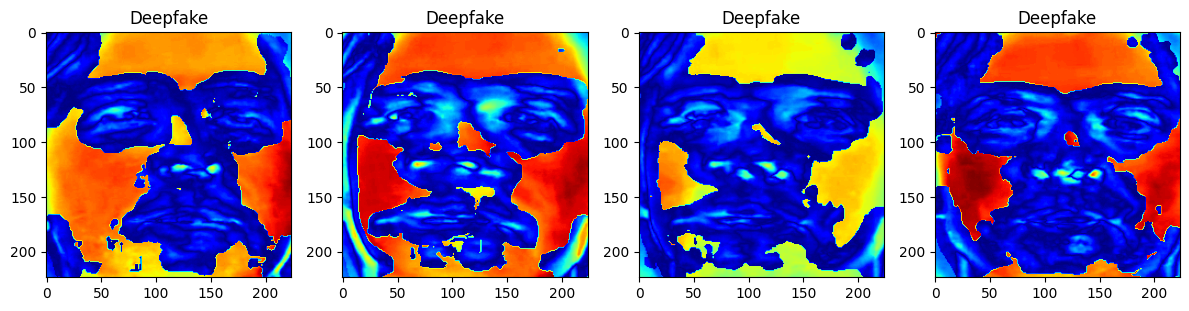

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))

ax[0].imshow(flow_df.loc[flow_df['label'] == 0, 'motion_residual'].iloc[0], cmap='jet')
ax[0].set_title('Deepfake')

ax[1].imshow(flow_df.loc[flow_df['label'] == 0, 'motion_residual'].iloc[1], cmap='jet')
ax[1].set_title('Deepfake')

ax[2].imshow(flow_df.loc[flow_df['label'] == 0, 'motion_residual'].iloc[2], cmap='jet')
ax[2].set_title('Deepfake')

ax[3].imshow(flow_df.loc[flow_df['label'] == 0, 'motion_residual'].iloc[3], cmap='jet')
ax[3].set_title('Deepfake')

plt.tight_layout()
plt.show()

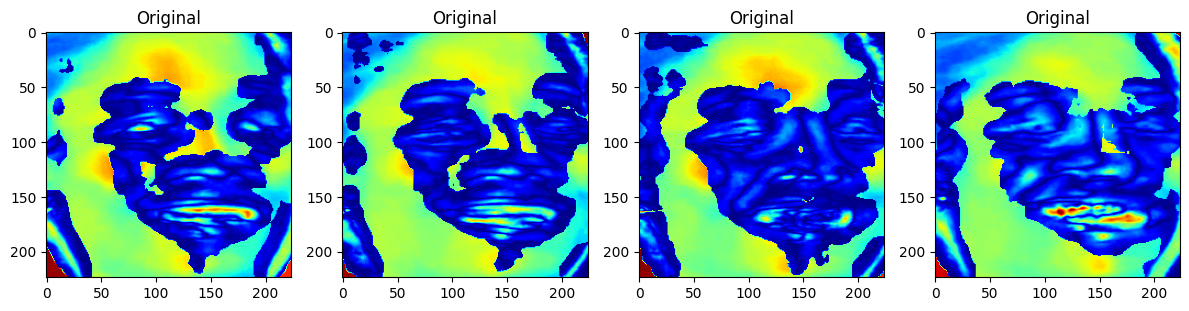

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))

ax[0].imshow(flow_df.loc[flow_df['label'] == 1, 'motion_residual'].iloc[0], cmap='jet')
ax[0].set_title('Original')

ax[1].imshow(flow_df.loc[flow_df['label'] == 1, 'motion_residual'].iloc[1], cmap='jet')
ax[1].set_title('Original')

ax[2].imshow(flow_df.loc[flow_df['label'] == 1, 'motion_residual'].iloc[2], cmap='jet')
ax[2].set_title('Original')

ax[3].imshow(flow_df.loc[flow_df['label'] == 1, 'motion_residual'].iloc[3], cmap='jet')
ax[3].set_title('Original')

plt.tight_layout()
plt.show()

In [6]:
def create_model(input_shape, num_features):
    # Input layer
    input_layer = Input(shape=input_shape)

    # Reshape motion_residual to have 3 channels
    x = tf.keras.backend.stack((input_layer,)*3, axis=-1)

    # Load pre-trained ResNet50 without the final classification layer
    base_model = ResNet50(include_top=False, input_tensor=x, weights='imagenet')

    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add new classification layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    output_layer = Dense(num_features)(x)  # remove activation function

    # Define the model with input and output layers
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

input_shape = (224, 224)
num_features = 1024  # choose desired number of output features
model = create_model(input_shape, num_features)
model.compile(loss='binary_crossentropy', optimizer='adam')

In [7]:
import numpy as np
from PIL import Image

# Group the flow_df by video_name
grouped_df = flow_df.groupby('video_name')

# Load motion_residual data and labels from each video
motion_residual_data = []
labels = []
for video_name, group in grouped_df:
    motion_residuals = []
    label = group['label'].iloc[0] # get the label of the video
    current_label = []
    for i, row in group.iterrows():
        motion_residual = row['motion_residual']
        motion_residual = Image.fromarray(motion_residual)
        motion_residual = motion_residual.resize(input_shape, resample=Image.BICUBIC)
        motion_residual = np.array(motion_residual)
        motion_residuals.append(motion_residual)
        current_label.append(label) # add label for each frame in the video
    if len(motion_residuals) > 30:
        motion_residuals = motion_residuals[:30]
        labels = labels[:30] # truncate labels for excess frames
    labels.append(mode(current_label))
    motion_residual_data.append(np.array(motion_residuals))
    # Reset motion_residuals and labels lists for next video

motion_residual_data = np.array(motion_residual_data)

# Reshape the motion_residual_data from (None, 30, 224, 224) to (None*30, 224, 224)
motion_residual_data_reshaped = motion_residual_data.reshape((-1, 224, 224))

# Normalize the data to have values between 0 and 1
motion_residual_data_reshaped = motion_residual_data_reshaped / 255.0

print(motion_residual_data_reshaped.shape)

features = model.predict(motion_residual_data_reshaped)  # get feature vectors
# print(features.shape)
# print(features.shape)

(270, 224, 224)
9/9 [==============================] - 8s 85ms/step


In [8]:
# Reshape the features from (270, 1024) to (9, 30, 1024)
features_reshaped = features.reshape((-1, 30, 1024))

# Print the shapes of the resulting arrays
print(features_reshaped.shape)

# Convert label list to numpy array
labels = np.array(labels)

# Split the data into training and testing sets with a 80-20 split
train_data, test_data, train_labels, test_labels = train_test_split(features_reshaped, labels, test_size=0.2, random_state=42)

# Print the shapes of the resulting arrays
print(f"Frame features in train set: {train_data.shape}")
print(f"Frame labels in train set: {train_labels.shape}")

(9, 30, 1024)
Frame features in train set: (7, 30, 1024)
Frame labels in train set: (7,)


In [9]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)